In [1]:
import matplotlib
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [2]:
# !pip install ibats_common
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble, preprocessing, metrics
from ibats_common.backend.factor import get_factor
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
from vnpy.trader.constant import Exchange, Interval
from vnpy.trader.database import database_manager
import ffn  # NOQA
import matplotlib
# 使用 Jupyter 内置方式显示
matplotlib.use('module://ipykernel.pylab.backend_inline')


C:\Users\zerenhe-lqb\AppData\Roaming\Python\Python37\site-packages\ffn\core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
2020-09-18 11:14:23,210 DEBUG peewee peewee.py.execute_sql:3087|('SELECT table_name FROM information_schema.tables WHERE table_schema = DATABASE() AND table_type != %s ORDER BY table_name', ('VIEW',))
2020-09-18 11:14:23,215 DEBUG peewee peewee.py.execute_sql:3087|('SELECT table_name FROM information_schema.tables WHERE table_schema = DATABASE() AND table_type != %s ORDER BY table_name', ('VIEW',))


In [3]:


def plot_bar(symbol="RB2009", exchange=Exchange.SHFE, interval=Interval.MINUTE,
             start=datetime(2019, 4, 1), end=datetime(2020, 10, 30),
             label_count=15, fig_size=(16, 6), label_rotation=15, time_format='%Y-%m-%d %H:%M:%S'):
    # Load history data
    bars = database_manager.load_bar_data(
        symbol=symbol, exchange=exchange,
        interval=interval, start=start, end=end)

    # Generate x, y
    x = [bar.datetime for bar in bars]
    y = [bar.close_price for bar in bars]

    # Show plot
    y_len = len(y)
    xticks = list(range(0, y_len, y_len // label_count))
    xlabels = [x[_].strftime(time_format) for _ in xticks]
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=label_rotation)
    plt.plot(y)
    plt.title(f"{symbol} {interval.value} {min(x).strftime(time_format)}~{max(x).strftime(time_format)}")
    plt.legend([symbol])
    plt.show()

2020-09-18 11:14:26,847 DEBUG peewee peewee.py.execute_sql:3087|('SELECT `t1`.`id`, `t1`.`symbol`, `t1`.`exchange`, `t1`.`datetime`, `t1`.`interval`, `t1`.`volume`, `t1`.`open_interest`, `t1`.`open_price`, `t1`.`high_price`, `t1`.`low_price`, `t1`.`close_price` FROM `dbbardata` AS `t1` WHERE (((((`t1`.`symbol` = %s) AND (`t1`.`exchange` = %s)) AND (`t1`.`interval` = %s)) AND (`t1`.`datetime` >= %s)) AND (`t1`.`datetime` <= %s)) ORDER BY `t1`.`datetime`', ['RB2009', 'SHFE', '1m', datetime.datetime(2019, 4, 1, 0, 0), datetime.datetime(2020, 10, 30, 0, 0)])


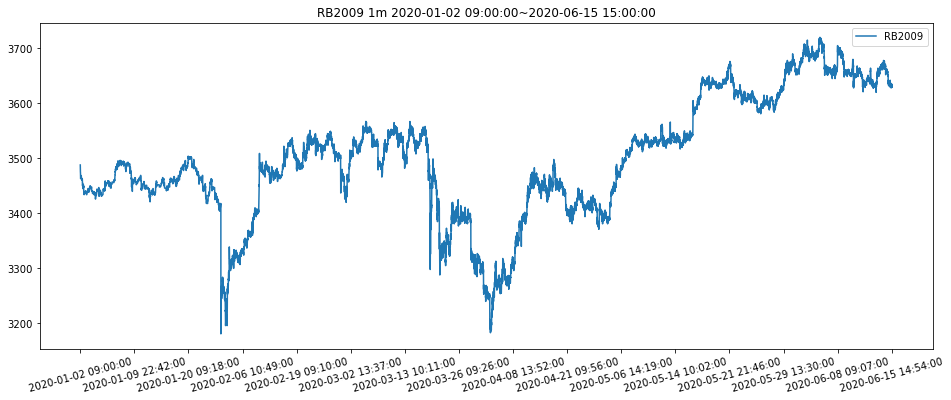

In [4]:
plot_bar(symbol="RB2009")

In [5]:
from ibats_common.backend.factor import get_factor

BAR_ATTRIBUTES = [
    'open_price', 'high_price', 'low_price', 'close_price',
    'datetime', 'volume',
]

def generate_factors(hist_bar_list):
    """整理缓存数据，生成相应的因子"""
    df = pd.DataFrame(
        [{key: getattr(_, key) for key in BAR_ATTRIBUTES}
         for _ in hist_bar_list]).set_index('datetime')
    df.index = pd.to_datetime(df.index)

    # 生成因子
    factor_df = get_factor(
        df,
        ohlcav_col_name_list=['open_price', 'high_price', 'low_price', 'close_price', None, 'volume'],
        dropna=False
    )
    return df, factor_df


获取数据

In [6]:
symbol="RB2009"
exchange=Exchange.SHFE
interval=Interval.MINUTE
start=datetime(2019, 4, 1)
end=datetime(2020, 10, 30)
bars = database_manager.load_bar_data(
    symbol=symbol, exchange=exchange,
    interval=interval, start=start, end=end)


2020-09-18 11:16:19,504 DEBUG peewee peewee.py.execute_sql:3087|('SELECT `t1`.`id`, `t1`.`symbol`, `t1`.`exchange`, `t1`.`datetime`, `t1`.`interval`, `t1`.`volume`, `t1`.`open_interest`, `t1`.`open_price`, `t1`.`high_price`, `t1`.`low_price`, `t1`.`close_price` FROM `dbbardata` AS `t1` WHERE (((((`t1`.`symbol` = %s) AND (`t1`.`exchange` = %s)) AND (`t1`.`interval` = %s)) AND (`t1`.`datetime` >= %s)) AND (`t1`.`datetime` <= %s)) ORDER BY `t1`.`datetime`', ['RB2009', 'SHFE', '1m', datetime.datetime(2019, 4, 1, 0, 0), datetime.datetime(2020, 10, 30, 0, 0)])


In [7]:
bars[0], bars[0].datetime, bars[-1].datetime

(BarData(gateway_name='DB', symbol='RB2009', exchange=<Exchange.SHFE: 'SHFE'>, datetime=datetime.datetime(2020, 1, 2, 9, 0, tzinfo=<DstTzInfo 'Asia/Shanghai' LMT+8:06:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=3.0, open_interest=2149.0, open_price=3488.0, high_price=3488.0, low_price=3488.0, close_price=3488.0),
 datetime.datetime(2020, 1, 2, 9, 0, tzinfo=<DstTzInfo 'Asia/Shanghai' LMT+8:06:00 STD>),
 datetime.datetime(2020, 6, 15, 15, 0, tzinfo=<DstTzInfo 'Asia/Shanghai' LMT+8:06:00 STD>))

构建因子矩阵

In [8]:
hist_bar_df, factor_df = generate_factors(bars)
len(bars), hist_bar_df.shape, factor_df.shape

(29047, (29047, 5), (29047, 111))

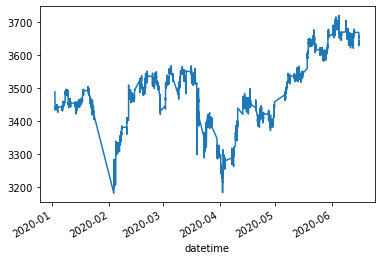

In [9]:
hist_bar_df['close_price'].plot()
plt.show()

构建y数据

In [10]:
y_s = hist_bar_df['close_price'].rolling(
    window=5).apply(lambda x: x.calc_calmar_ratio())

In [11]:
np.sum(y_s<=0), np.sum(y_s>0)

(13387, 11565)

数据整理，剔除无效数据

In [32]:
# 剔除无效数据
is_available = ~(np.isinf(y_s) | np.isnan(y_s) | np.any(np.isnan(factor_df), axis=1))
available_hist_bar_df = hist_bar_df[is_available]
x_arr = available_hist_bar_df.to_numpy()
y_arr = y_s[is_available]
# 生成 -1 1 分类结果
y_arr[y_arr > 0] = 1
y_arr[y_arr <= 0] = -1
x_train_arr, x_test_arr, y_train_arr, y_test_arr = train_test_split(
    x_arr, y_arr, test_size=0.3)

In [13]:
# 剔除无效数据
is_available = ~(np.isinf(y_s) | np.isnan(y_s) | np.any(np.isnan(factor_df), axis=1))
x_arr = factor_df[is_available].to_numpy()
y_arr = y_s[is_available]
# 生成 -1 1 分类结果
y_arr[y_arr > 0] = 1
y_arr[y_arr <= 0] = -1
x_train_arr, x_test_arr, y_train_arr, y_test_arr = train_test_split(
    x_arr, y_arr, test_size=0.3)

In [14]:
x_arr.shape, y_arr.shape, np.sum(y_arr==-1), np.sum(y_arr==1)

((19670, 111), (19670,), 13333, 6337)

创建分类器

In [15]:
# Train classifier
# 弱学习器的最大迭代次数，
# n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，
# 一般选择一个适中的数值。默认是50。
# 在实际调参的过程中，我们常常将n_estimators和learning_rate一起考虑。
n_estimators = 50
# 对于同样的训练集拟合效果，
# 较小的ν意味着我们需要更多的弱学习器的迭代次数。
# 通常用步长和迭代最大次数一起来决定算法的拟合效果。
# 所以这两个参数n_estimators和learning_rate要一起调参。
# 一般来说，可以从一个小一点的ν开始调参，默认是1。
learning_rate = 0.1
scaler = preprocessing.MinMaxScaler()
clf = ensemble.AdaBoostClassifier(
    n_estimators=n_estimators, learning_rate=learning_rate)

开始训练

In [16]:
x_train_trans_arr = scaler.fit_transform(x_train_arr)
# print 'type(X_train_trans),X_train_trans[:5,:]\n%s\n%s'%(type(X_train_trans),X_train_trans[:5,:])
# print 'type(Y_train),Y_train.head()\n%s\n%s'%(type(Y_train),Y_train.head())
clf.fit(x_train_trans_arr, y_train_arr)
# 交叉检验
y_pred = clf.predict(x_train_trans_arr)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(y_train_arr, y_pred) * 100))
x_test_trans = scaler.transform(x_test_arr)
y_pred = clf.predict(x_test_trans)
y_pred_prob = clf.predict_proba(x_test_trans)
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(y_test_arr, y_pred) * 100))
print('Log-loss on test set = {:.5f}'.format(metrics.log_loss(y_test_arr, y_pred_prob) * 100))


Accuracy on train set = 90.27%
Accuracy on test set = 89.14%
Log-loss on test set = 65.65922


开始交叉验证训练

In [31]:
import itertools

scaler = preprocessing.MinMaxScaler()
x_trans_arr = scaler.fit_transform(x_arr)
for n, rate in itertools.product(range(30, 100, 20), [0.5, 0.1, 0.01]):
    estimator = ensemble.AdaBoostClassifier(
    n_estimators=n, learning_rate=rate)
    result = np.array(cross_val_score(estimator, x_trans_arr, y_arr)) * 100
    print(f'n={n:3d} rate={rate:.2f} mean_res={np.mean(result):.2f}, std_res={np.std(result):.5f}, result={result}')

n= 30 rate=0.50 mean_res=82.22, std_res=7.39055, result=[82.61311642 86.90899847 86.47686833 87.26487036 67.81901373]
n= 30 rate=0.10 mean_res=87.76, std_res=1.05282, result=[88.99339095 87.74783935 86.65480427 86.52770717 88.89171327]
n= 30 rate=0.01 mean_res=86.51, std_res=1.28890, result=[88.81545501 86.01931876 85.30757499 85.46009151 86.95983732]
n= 50 rate=0.50 mean_res=82.29, std_res=7.42697, result=[82.74021352 86.88357905 86.50228775 87.51906457 67.81901373]
n= 50 rate=0.10 mean_res=87.71, std_res=0.84744, result=[88.4341637  87.46822572 86.60396543 87.13777326 88.91713269]
n= 50 rate=0.01 mean_res=86.57, std_res=1.31558, result=[88.81545501 86.01931876 85.30757499 85.46009151 87.26487036]
n= 70 rate=0.50 mean_res=82.50, std_res=7.52462, result=[83.04524657 87.061515   86.75648195 87.82409761 67.81901373]
n= 70 rate=0.10 mean_res=84.27, std_res=6.55851, result=[88.1799695  87.62074225 86.88357905 87.46822572 71.17437722]
n= 70 rate=0.01 mean_res=86.63, std_res=1.38095, result=

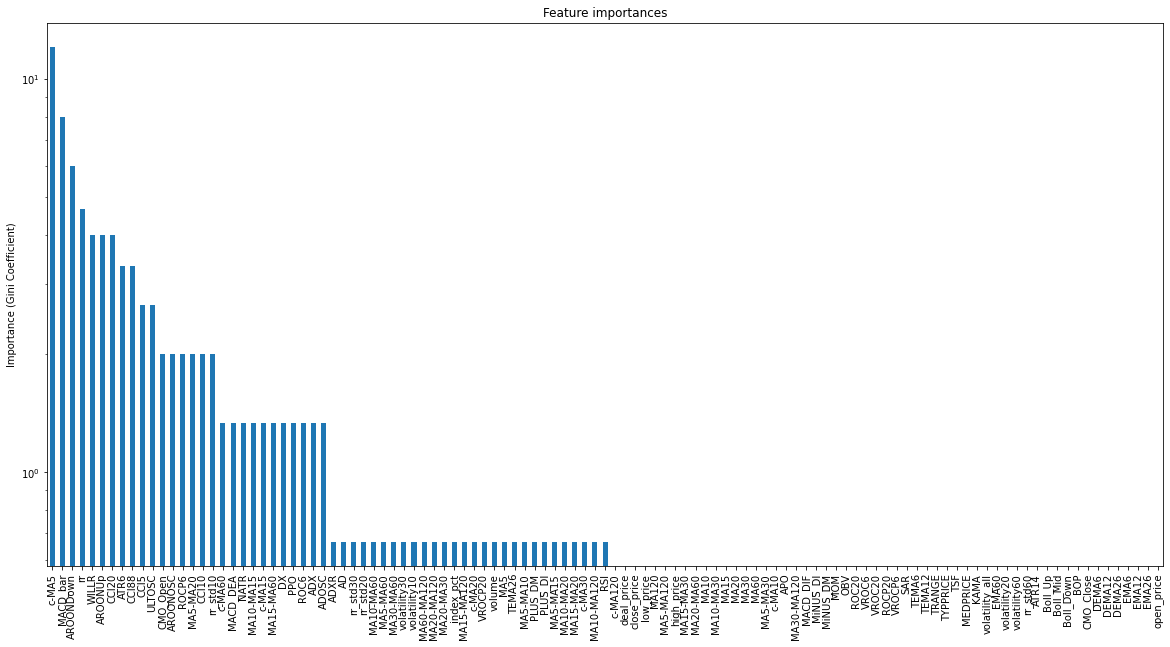

In [30]:
feature_importances = pd.Series(clf.feature_importances_, index=factor_df.columns) * 100
feature_importances.sort_values(ascending=False, inplace=True)
ax = feature_importances.plot(kind='bar', figsize=(20,10))
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');
ax.set_yscale("log")

尝试使用近20天的数据，滚动向前，查看预测未来5天的Y值准确率，以及 feature importance 的变化情况

In [59]:
win_size_days = 20
predict_future_n_days = 5
# 有效历史数据的日期序列
available_hist_bar_df_date_s = pd.Series(available_hist_bar_df.index).apply(lambda x:x.date())
# Unique 日期序列
date_s = pd.Series(available_hist_bar_df_date_s.unique())
for idx in range(win_size_days, data_s.shape[0]-predict_future_n_days):
    dates = date_s.iloc[idx-win_size_days:idx]
    date_from, date_to = pd.to_datetime(dates.min()), pd.to_datetime(dates.max())
    sub_available = (date_from<=available_hist_bar_df.index) & (available_hist_bar_df.index<date_to)
    sub_hist_bar_df = available_hist_bar_df[sub_available]
    sub_y_arr = y_arr[sub_available]
    break
    


TypeError: Cannot compare tz-naive and tz-aware datetime-like objects

In [64]:
d = pd.to_datetime(dates.min())
available_hist_bar_df.index[0], d

AttributeError: 'datetime.date' object has no attribute 'astimezone'